In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [ ]:
import numpy as np

with np.load('public_data.npz',allow_pickle=True) as data:
    print(data.files) # print the names of the arrays
    print(data['data']) # print the contents of arr_0
    print(data['labels']) # print the contents of arr_1
    X = data['data']
    y = data['labels']

['data', 'labels']
[[[[ 20.  38.   0.]
   [ 44.  62.  22.]
   [151. 173. 127.]
   ...
   [177. 220. 149.]
   [180. 224. 149.]
   [181. 225. 148.]]

  [[ 18.  35.   1.]
   [ 12.  29.   0.]
   [ 85. 106.  65.]
   ...
   [177. 220. 149.]
   [179. 223. 148.]
   [179. 223. 146.]]

  [[ 12.  23.   6.]
   [  9.  22.   2.]
   [  1.  17.   0.]
   ...
   [171. 213. 147.]
   [170. 213. 142.]
   [170. 213. 141.]]

  ...

  [[  3.  13.   2.]
   [  6.  16.   5.]
   [ 11.  18.  10.]
   ...
   [101. 139.  82.]
   [ 83. 115.  66.]
   [ 81. 113.  64.]]

  [[  6.  17.   0.]
   [  8.  19.   2.]
   [ 15.  23.   8.]
   ...
   [ 87. 125.  68.]
   [ 98. 130.  80.]
   [ 90. 122.  73.]]

  [[  6.  18.   0.]
   [  8.  20.   0.]
   [ 19.  27.  12.]
   ...
   [ 79. 117.  60.]
   [106. 138.  88.]
   [101. 133.  84.]]]


 [[[ 94. 125.  83.]
   [ 46.  79.  34.]
   [ 62. 103.  47.]
   ...
   [129. 178. 133.]
   [125. 174. 127.]
   [124. 173. 126.]]

  [[ 67.  98.  56.]
   [ 31.  64.  19.]
   [ 57.  98.  42.]
   ...
  

In [ ]:
X.shape, y.shape

((5200, 96, 96, 3), (5200,))

In [ ]:

# Remove the outliers (Cartoon images)
# This code notes index of cartoon images. Then through a loop, all matching numpy values to that of the cartoon image were removed from the dataset
similar1,similar2=0,0

sam1=X[338]
sam2=X[1554]

indices=[]
k=0
for i in X:
  if (i==sam1).all() :
    similar1+=1
    indices.append(k)


  if (i==sam2).all():
    similar2+=1
    indices.append(k)
  k+=1

indices = sorted(indices, reverse=True)
X=np.delete(X,indices,axis=0)
y=np.delete(y,indices,axis=0)

print("Number Trololo outlier",similar1,"shrek outlier",similar2)

Number Trololo outlier 98 shrek outlier 98


In [ ]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)


from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LayerNormalization
from keras.layers import GlobalAveragePooling2D
#from tensorflow.keras.applications. import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns



2.14.0


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:

#Balancing the dataset for healthy and unhealthy images
#Normalise the data between [0,1]

preprocessing = tf.keras.Sequential([
        tfkl.RandomFlip("vertical"),
        tfkl.RandomTranslation(0.32,0.23),
        tfkl.RandomFlip("horizontal"),
], name='preprocessing')
X=X/255.0

k=0
for i in y:
    if (i=="unhealthy" ) :
        if k%3 ==0 :
            x1=np.copy(preprocessing(X[k]))
            X = np.append(X, [x1],axis=0)
            y= np.append(y, [i],axis=0)
        if k%4 ==0:
            x1=np.copy(preprocessing(X[k]))
            X = np.append(X, [x1],axis=0)
            y= np.append(y, [i],axis=0)
    k+=1

In [ ]:
print("Data X", X.shape)
print("Labels y", y.shape)

Data X (6084, 96, 96, 3)
Labels y (6084,)


In [ ]:
# As we can see with the help of data augmentation the dataset is balanced
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
healthy      3101
unhealthy    2983
Name: digit, dtype: int64


In [ ]:
label =np.where(y == 'healthy', 0, 1)

In [ ]:
# Train_validation and test split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, label, random_state=seed, test_size=0.1, shuffle=True)

In [ ]:
# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (5475, 96, 96, 3)
Training-Validation Label Shape: (5475,)
Test Data Shape: (609, 96, 96, 3)
Test Label Shape: (609,)


In [ ]:
#Train and validation split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1,stratify = y_train_val, shuffle=True)

In [ ]:
print('Training set shape:\t',X_train.shape, y_train.shape)
print('Validation set shape:\t',X_val.shape, y_val.shape)
print('Test set shape:\t\t',X_test.shape, y_test.shape)

Training set shape:	 (4927, 96, 96, 3) (4927,)
Validation set shape:	 (548, 96, 96, 3) (548,)
Test set shape:		 (609, 96, 96, 3) (609,)


In [ ]:
#Adding more data to the training set using spatial tranformation
xr=np.copy(X_train[1000:4000])
yr=np.copy(y_train[1000:4000])

X_train = np.append(X_train, preprocessing(xr),axis=0)
y_train = np.append(y_train, yr,axis=0)


In [ ]:
print('Training set shape:\t',X_train.shape, y_train.shape)
print('Validation set shape:\t',X_val.shape, y_val.shape)
print('Test set shape:\t\t',X_test.shape, y_test.shape)

Training set shape:	 (7927, 96, 96, 3) (7927,)
Validation set shape:	 (548, 96, 96, 3) (548,)
Test set shape:		 (609, 96, 96, 3) (609,)


In [ ]:
# Expand also the labels dimension moving from (x,) to (x, 1), with x cardinality
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train.shape)
print("Training-Validation Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (7927, 96, 96, 3)
Training-Validation Label Shape: (7927, 1)
Validation Data Shape: (548, 96, 96, 3)
Validation Label Shape: (548, 1)
Test Data Shape: (609, 96, 96, 3)
Test Label Shape: (609, 1)


In [ ]:
labels = {0:'healthy', 1:'unhealthy'}

In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
0    4052
1    3875
Name: digit, dtype: int64


In [ ]:
# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

In [ ]:
# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train.shape)
print("Training-Validation Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training-Validation Data Shape: (7927, 96, 96, 3)
Training-Validation Label Shape: (7927, 2)
Validation Data Shape: (548, 96, 96, 3)
Validation Label Shape: (548, 2)
Test Data Shape: (609, 96, 96, 3)
Test Label Shape: (609, 2)


In [ ]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[1])           # Display the categorical label
print('"Default" label:', np.argmax(y_train[1]))   # Display the equivalent numeric label

Categorical label: [0. 1.]
"Default" label: 1


In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model
batch_size = 160     # Batch size for training
epochs = 40       # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 40
Batch Size: 160
Input Shape: (96, 96, 3)
Output Shape: 2


**Our best model in the final phase with the below scores** <br>

Accuracy: 0.8220 <br>
Precision:	0.7306 <br>
Recall: 0.8421 <br>
F1 Score:	0.7824

In [ ]:
#Initializing the ConvNeXtLarge model

model1 = tf.keras.applications.ConvNeXtLarge(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
    )

785596384/785596384 [==============================] - 7s 0us/step


In [ ]:
# The convolutional layer in the convnextlarge was set to not trainable

model1.trainable = False
for layer in model1.layers:
    layer.trainable = False

In [ ]:
# Create an input layer with the shape of our images
inputs = tfk.Input(input_shape)

# Connect ConvNeXtXLarge to the input
x = model1(inputs)


x = tfkl.Dense(514, activation='relu')(x)
x = tfkl.Dropout(0.3)(x)

# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 dense (Dense)               (None, 514)               790018    
                                                                 
 dropout (Dropout)           (None, 514)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1030      
                                                                 
Total params: 197021384 (751.58 MB)
Trainable params: 791048 (3.02 MB)
Non-trainable params: 196230336 (748.56 MB)
____________

In [ ]:
# Train the model
tl_history = model.fit(
    x = (X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = ((X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

Epoch 1/40
50/50 [==============================] - 98s 1s/step - loss: 0.5836 - accuracy: 0.7548 - val_loss: 0.3751 - val_accuracy: 0.8303
Epoch 2/40
50/50 [==============================] - 51s 1s/step - loss: 0.3414 - accuracy: 0.8518 - val_loss: 0.3158 - val_accuracy: 0.8558
Epoch 3/40
50/50 [==============================] - 52s 1s/step - loss: 0.2859 - accuracy: 0.8750 - val_loss: 0.3081 - val_accuracy: 0.8613
Epoch 4/40
50/50 [==============================] - 50s 1s/step - loss: 0.2475 - accuracy: 0.9003 - val_loss: 0.2838 - val_accuracy: 0.8668
Epoch 5/40
50/50 [==============================] - 52s 1s/step - loss: 0.2113 - accuracy: 0.9161 - val_loss: 0.2683 - val_accuracy: 0.8832
Epoch 6/40
50/50 [==============================] - 50s 1s/step - loss: 0.1907 - accuracy: 0.9271 - val_loss: 0.2473 - val_accuracy: 0.8960
Epoch 7/40
50/50 [==============================] - 51s 1s/step - loss: 0.1709 - accuracy: 0.9345 - val_loss: 0.2810 - val_accuracy: 0.8668
Epoch 8/40
50/50 [==

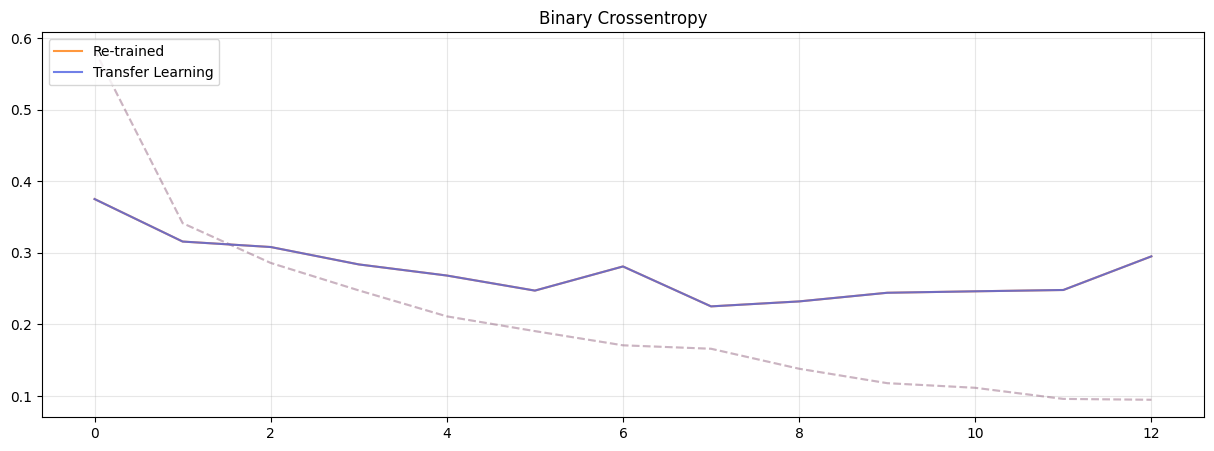

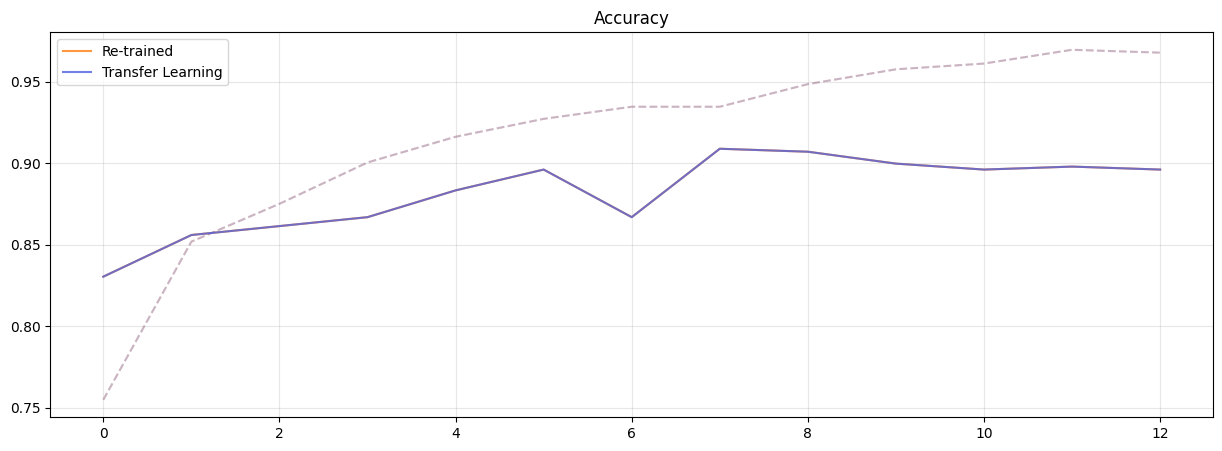

In [ ]:
# Plot the re-trained and the transfer learning ConvNeXtLarge training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

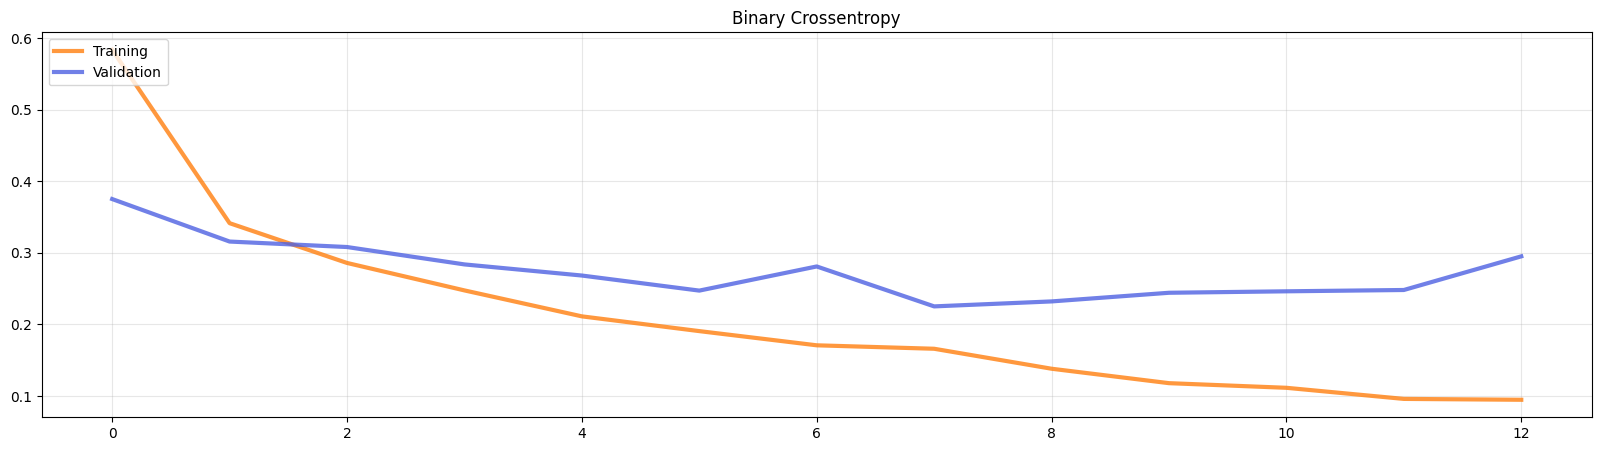

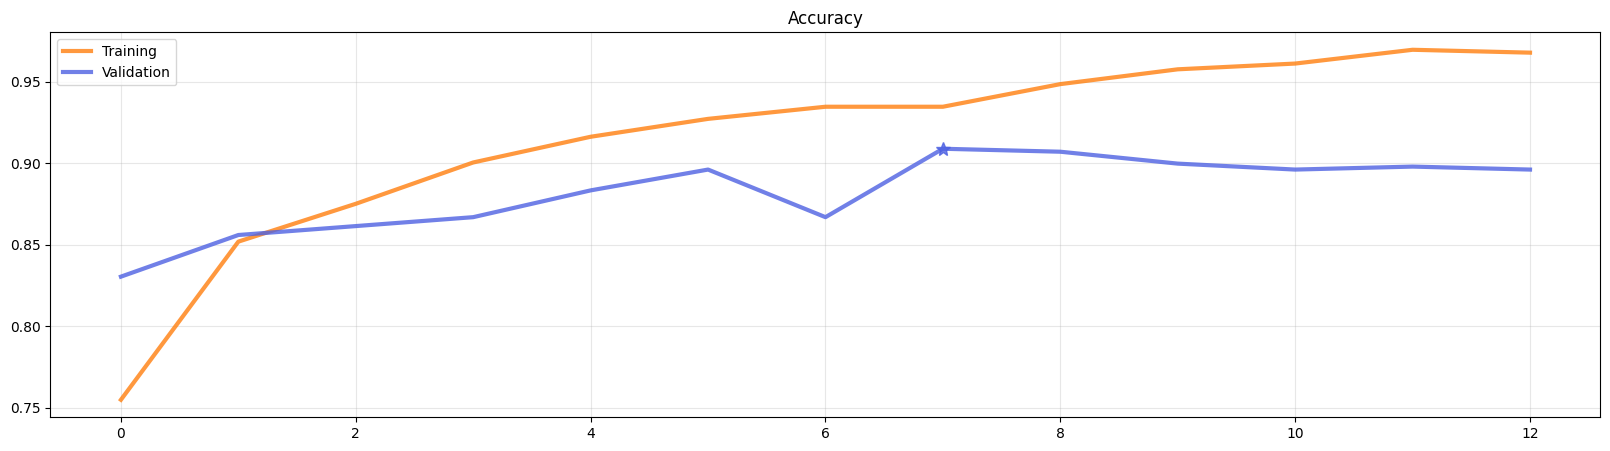

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(tl_history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(tl_history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(tl_history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(tl_history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(tl_history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, tl_history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Save the best model
model.save('/gdrive/MyDrive/ConvNextLarge')


In [ ]:
del model

Input image


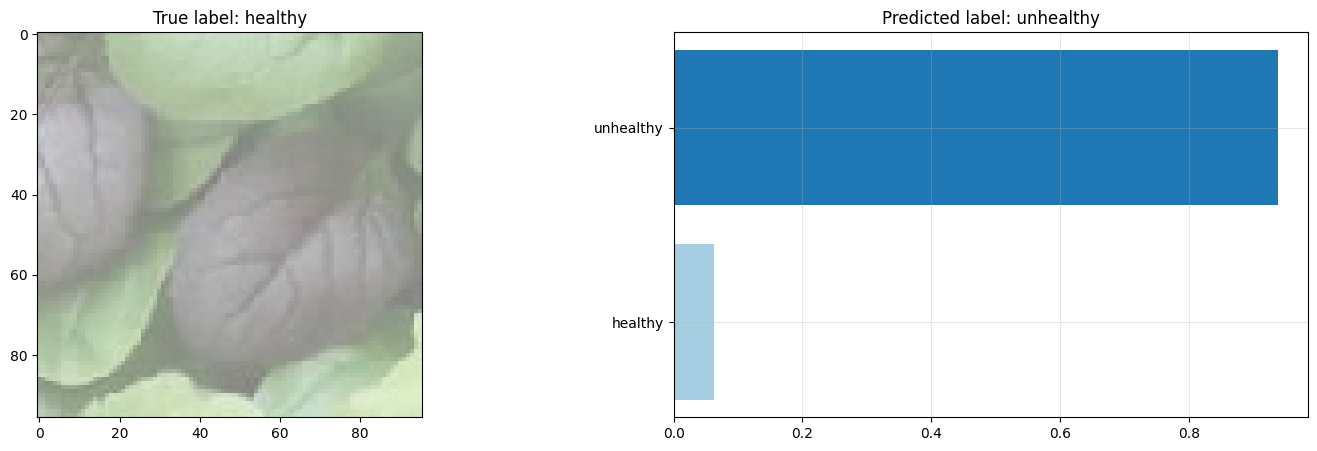

In [ ]:
# Load the saved ConvNeXtLarge model
model = tfk.models.load_model('/gdrive/MyDrive/ConvNextLarge')

num_images = 500

# Choose a random image for visualization
image = np.random.randint(0, num_images)

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow((X_test[image] + 1) / 2)
ax1.set_title('True label: ' + labels[np.argmax(y_test[image])])
prediction = model.predict(np.expand_dims(X_test[image], axis=0), verbose=0)
ax2.barh(list(labels.values()), np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test*255, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (609, 2)


Accuracy: 0.9031
Precision: 0.9042
Recall: 0.9023
F1: 0.9028


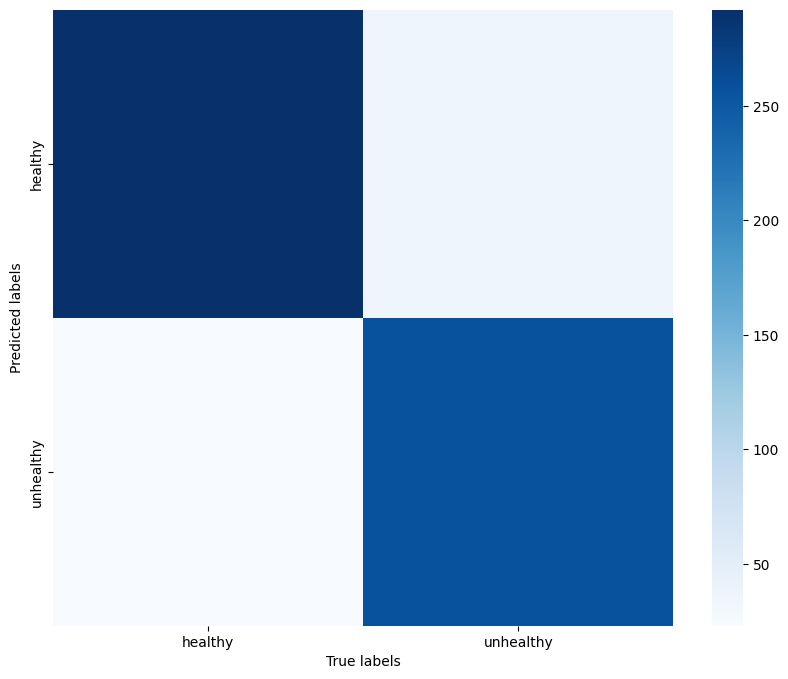

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

**FINE TUNING**

In [ ]:
# Loading the ConvNeXtLarge model

ft_model = tfk.models.load_model('/gdrive/MyDrive/ConvNextLarge')
ft_model.summary()

In [ ]:
# Freezing some of the layers of the ConvNeXtLarge model

ft_model.get_layer('convnext_large').trainable = True

# Freeze first N layers, e.g., until the 133rd one
N = 100
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[1:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)

ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy'])
ft_model.summary()

In [ ]:
# Train the model with different learning rate 1e-5
tl_history = ft_model.fit(
    x = (X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = ((X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history

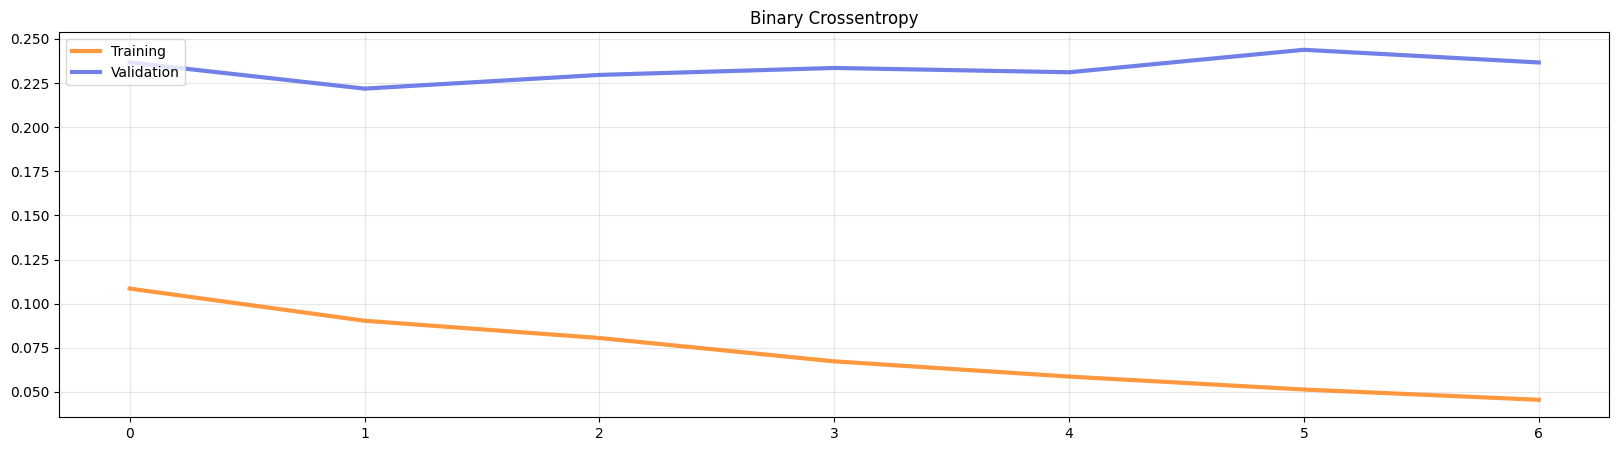

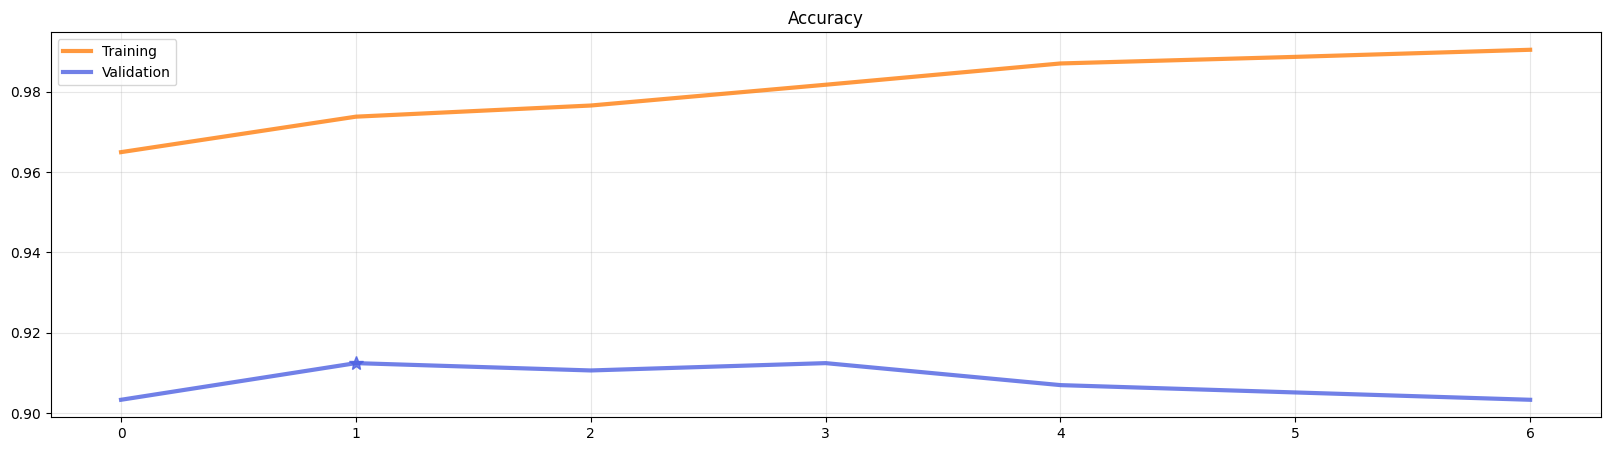

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(tl_history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(tl_history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(tl_history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(tl_history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(tl_history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, tl_history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Save the best model
ft_model.save('/gdrive/MyDrive/ConvNextLarge_finetune_v1')


In [ ]:
del ft_model

Input image


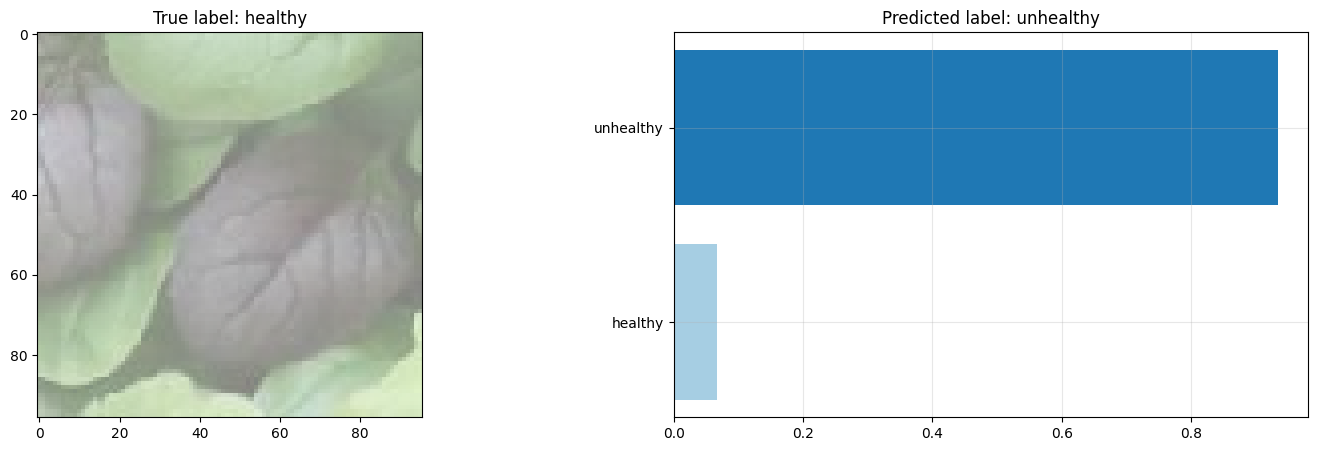

In [ ]:
# Load the saved ConvNeXtLarge fine-tuned model
model = tfk.models.load_model('/gdrive/MyDrive/ConvNextLarge_finetune_v1')

num_images = 500

# Choose a random image for visualization
image = np.random.randint(0, num_images)

# Display the input image, true label, and predicted label
print('Input image')
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 5)
ax1.imshow((X_test[image] + 1) / 2)
ax1.set_title('True label: ' + labels[np.argmax(y_test[image])])
prediction = model.predict(np.expand_dims(X_test[image], axis=0), verbose=0)
ax2.barh(list(labels.values()), np.squeeze(prediction, axis=0), color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: ' + labels[np.argmax(prediction)])
ax2.grid(alpha=0.3)
plt.show()

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test*255, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (609, 2)


Accuracy: 0.9048
Precision: 0.9067
Recall: 0.9036
F1: 0.9044


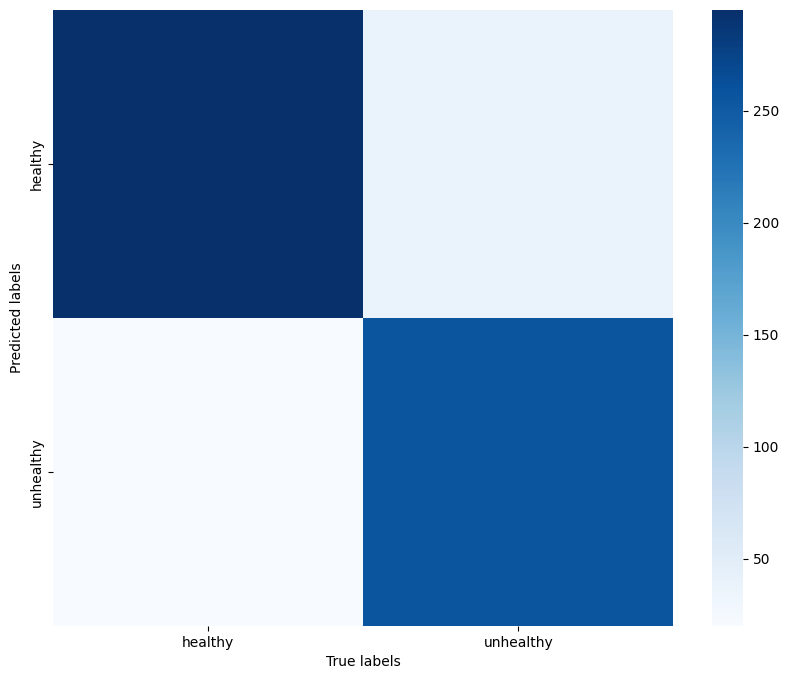

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

**The below model got 91% accuracy in the development phase and 80% accuracy in final phase in CodaLab**

**Transfer Learning and Fine Tuning with ConvNextBase**

* Freezing almost all layers to maintain the low level and high level features and training the  the top few layers.
* Using callbacks Early stopping and Reduce LR on plateau .


In [ ]:
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
#tf.keras.applications.convnext.ConvNeXtXLarge

X_train1 = np.copy(X_train)
X_val1=np.copy(X_val)
X_test1=np.copy(X_test)
GAP = layers.GlobalAveragePooling2D()
flatten_layer = tf.keras.layers.Flatten()
dense_layer_3 = layers.Dense(1024, activation='relu')
dense_layer_4 = layers.Dense(16, activation='relu')
dense_layer_5 = layers.Dense(512, activation='relu')

dense_layer_1 = layers.Dense(1024, activation='relu')
dropout = tf.keras.layers.Dropout(0.3)
dense_layer_2 = layers.Dense(256, activation=None, kernel_initializer = tf.keras.initializers.HeUniform(34))
prediction_layer = layers.Dense(2, activation='softmax')
batch_norm = layers.BatchNormalization()
Relu = layers.ReLU()
    # Data Augmentation
print("aaa")

#datagen.flow(X_train, y_train, batch_size=512),
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.ConvNeXtBase(
    input_shape=(96, 96, 3),
    include_top=False,
    weights= "imagenet",
    #pooling='avg',
)
mobile.trainable = True


lr_patience = 3
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.5,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='min',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-5           # Minimum learning rate
)


for layer in mobile.layers[:40]:
    layer.trainable = False


for layer in mobile.layers:
    print(layer ,layer.trainable)

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile, show_shapes=True)

inputs = tfk.Input(shape=(96, 96, 3))

x = mobile(inputs)
x=GAP(x)
# Add a Dense layer with 2 units and softmax activation as the classifier
#x=dropout(x)
#x = dense_layer_4(x)
x=dropout(x)
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(0.001), metrics=['accuracy'])

# Display model summary
model.summary()
# Train the model
history = model.fit(
    #datagen.flow(preprocess_input(X_train1), y_train, batch_size=512),
    x= (X_train1*255),
    y = y_train,
    batch_size = 160,
    epochs = 1000,
    validation_data = (X_val1*255, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=4, restore_best_weights=True),lr_scheduler]
).history

**The below are the other model that we tried**

**Lenet**

The scores that we reached in our local machine: <br>
Accuracy: 0.6577 <br>
Precision: 0.6446 <br>
Recall: 0.6016 <br>
F1: 0.5954 <br>

The scores were not good so we didn't submit the model.


In [ ]:
def build_LeNet(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=6,
        kernel_size=(5,5),
        padding='same',
        activation='tanh',
        name='conv1'
    )(input_layer)

    pool1 = tfkl.MaxPooling2D(
        pool_size=(2,2),
        name='mp1'
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=16,
        kernel_size=(5,5),
        padding='valid',
        activation='tanh',
        name='conv2'
    )(pool1)

    pool2 = tfkl.MaxPooling2D(
        pool_size =(2,2),
        name='mp2'
    )(conv2)

    flattening_layer=tfkl.Flatten(
        name='flatten'
    )(pool2)

    classifier_layer=tfkl.Dense(
        units=120,
        activation='tanh',
        name='dense1'
    )(flattening_layer)

    classifier_layer = tfkl.Dense(
        units=84,
        activation='tanh',
        name='dense2'
    )(classifier_layer)

    output_layer = tfkl.Dense(
        units=output_shape,
        activation='softmax',
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='LeNet')

    # Compile the model
    # We can also use optimizer = tfk.optimizers.AdamW()
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model


# Build the LeNet model and display its summary
model = build_LeNet(input_shape, output_shape)
model.summary()

# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('LeNet_MNIST')

**VGG9**

The scores that we reached in our local machine: <br>

Accuracy: 0.7808 <br>
Precision: 0.7881 <br>
Recall: 0.7467 <br>
F1: 0.755 <br>

We used Vgg9 with and without layer normalization

The scores were good for the start, so we submitted the model and got 52% accuracy in the CodaLab.



In [ ]:
def build_quasiVGG9(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv00')(input_layer)
    x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv01')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv10')(x)
    x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv11')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv20')(x)
    x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv21')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)


    x = tfkl.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',name='conv30')(x)
    x = tfkl.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',name='conv31')(x)
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=output_shape,activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Convnet')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(weight_decay=5e-4), metrics=['accuracy'])

    # Return the model
    return model

def vgg9_layer_noramlisation_used(input_shape, output_shape, seed=seed):

    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv00')(input_layer)
    x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv01')(x)
    x = tfkl.LayerNormalization()(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv10')(x)
    x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv11')(x)
    x = tfkl.LayerNormalization()(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv20')(x)
    x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv21')(x)
    x = tfkl.LayerNormalization()(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)


    output_layer = tfkl.Dense(units=output_shape,activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Convnet')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(weight_decay=1e-4), metrics=['accuracy'])

    # Return the model
    return model


# Build the quasiVGG9 model and display its summary
model = build_quasiVGG9(input_shape, output_shape)
model.summary()

# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train_val,
    y=y_train_val,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('LatestModel')


**Transfer learning using Xception**

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(X_train_val,y_train_val, epochs=epochs, validation_data=(X_test,y_test))



**Transfer Learning with MobileNet model**

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess
X_train1 = np.copy(X_train)
X_val1=np.copy(X_val)
X_test1=np.copy(X_test)
preprocess_input =mobilenetv2_preprocess
    # Data Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,

    fill_mode='nearest',
    #rescale=1./255.
    )
#datagen.flow(X_train, y_train, batch_size=512),
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights= "imagenet",
    pooling='avg',
)
mobile.trainable = False

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile, show_shapes=True)

inputs = tfk.Input(shape=(96, 96, 3))

x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()
# Train the model
history = model.fit(
    #datagen.flow(preprocess_input(X_train1), y_train, batch_size=512),
    x= preprocess_input(X_train1),
    y = y_train,
    batch_size = 512,
    epochs = 1000,
    validation_data = (preprocess_input(X_val1), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=25, restore_best_weights=True)]
).history

**Transfer Learning and Fine Tuning with ResNet50**

* Freezing lower layers to maintain the low level features and training the high level features at the top layers.
* Using callbacks Early stopping and Reduce LR on plateau.


In [ ]:
X_train1 = np.copy(X_train)
X_val1=np.copy(X_val)
X_test1=np.copy(X_test)


GAP = layers.GlobalAveragePooling2D()
flatten_layer = tf.keras.layers.Flatten()
dense_layer_3 = layers.Dense(256, activation='relu')
dense_layer_4 = layers.Dense(256, activation='relu',)
dense_layer_5 = layers.Dense(32, activation='relu')

dense_layer_1 = layers.Dense(1024, activation='relu')
dropout = tf.keras.layers.Dropout(0.5)
dense_layer_2 = layers.Dense(512, activation=None, kernel_initializer = tf.keras.initializers.HeUniform(42)
                            ,activity_regularizer =tf.keras.regularizers.L2(2.))
prediction_layer = layers.Dense(2, activation='softmax')
batch_norm = layers.BatchNormalization()
Relu = layers.ReLU()



lr_patience = 3
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.5,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='min',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-5           # Minimum learning rate
)



mobile = tfk.applications.ResNet50(
    input_shape=(96, 96, 3),
    include_top=False,
    weights= "imagenet",

)
mobile.trainable = True

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile, show_shapes=True)

inputs = tfk.Input(shape=(96, 96, 3))
N = 96
for i, layer in enumerate(mobile.layers[:N]):
    layer.trainable=False
    print( layer , layer.trainable)


x = mobile(inputs)
x=GAP(x)
# Add a Dense layer with 2 units and softmax activation as the classifier
x=dropout(x)
#x = dense_layer_1(x)
x = dense_layer_2(x)
#x = dense_layer_5(x)
#x=flatten_layer(x)
x=dropout(x)




outputs = tfkl.Dense(2, activation='softmax')(x)



# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(0.0001), metrics=['accuracy'])

# Display model summary
model.summary()
# Train the model
history = model.fit(
    x= resnet_preprocess(X_train1),
    y = y_train,
    batch_size = 256,
    epochs = 1000,
    validation_data = (resnet_preprocess(X_val1), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True),lr_scheduler]
).history

**AlexNet Model**

In [ ]:
def build_AlexNet(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=96,
        kernel_size=(11,11),
        strides=(4,4),
        padding='valid',
        activation='relu',
        name='conv1'
    )(input_layer)

    pool1 = tfkl.MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2),
        padding='valid',
        name='mp1'
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=256,
        kernel_size=(11,11),
        strides=(1,1),
        padding='valid',
        activation='relu',
        name='conv2'
    )(pool1)

    pool2 = tfkl.MaxPooling2D(
        pool_size =(2,2),
        strides=(2,2),
        padding='valid',
        name='mp2'
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=384,
        kernel_size=(3,3),
        strides=(1,1),
        padding='valid',
        activation='relu',
        name='conv3'
    )(pool2)

    conv4 = tfkl.Conv2D(
        filters=384,
        kernel_size=(3,3),
        strides=(1,1),
        padding='valid',
        activation='relu',
        name='conv4'
    )(conv3)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3,3),
        strides=(1,1),
        padding='valid',
        activation='relu',
        name='conv5'
    )(conv4)

    pool3 = tfkl.MaxPooling2D(
        pool_size =(2,2),
        strides=(2,2),
        padding='valid',
        name='mp3'
    )(conv5)

    flattening_layer=tfkl.Flatten(
        name='flatten'
    )(pool3)

    classifier_layer=tfkl.Dense(
        units=4096,
        activation='relu',
        name='dense1'
    )(flattening_layer)

    classifier_layer = tfkl.Dense(
        units=4096,
        activation='relu',
        name='dense2'
    )(classifier_layer)

    output_layer = tfkl.Dense(
        units=output_shape,
        activation='softmax',
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='AlexNet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model


model = build_AlexNet(input_shape, output_shape)
model.summary()

**ConvNextLarge**

In [ ]:
model_xl = tf.keras.applications.ConvNeXtXLarge(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling='avg',
)

model_xl.trainable = False
for layer in model_xl.layers:
  layer.trainable = False

SEED = 42


inputs = tfk.Input(input_shape)
x = model_xl(inputs)

x = tfkl.Dense(256, activation='relu')(x)
x = tfkl.Dropout(0.3)(x)

outputs = tfkl.Dense(2, activation='softmax')(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
model.summary()

t1_history = model.fit(
    x = (X_train*255),
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = ((X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)]
).history


output
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 convnext_xlarge (Functiona  (None, 2048)              348147968
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
=================================================================
Total params: 348673026 (1.30 GB)
Trainable params: 525058 (2.00 MB)
Non-trainable params: 348147968 (1.30 GB)
_________________________________________________________________

Accuracy: 0.9064
Precision: 0.9075
Recall: 0.9056
F1: 0.9061